**Load the necessary libraries**
 - pandas: For data manipulation and analysis
 - glob: For file listing
 - re: For regular expressions
 - matplotlib and seaborn: For plotting

In [1]:
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Load Data**

- List all CSV files in the specified directory.
- Read each CSV file into a DataFrame and concatenate them into a single DataFrame.

In [2]:
# List the files in the directory
file_list = glob.glob("kb_csv_files/KB_metadata_*.csv")

# Read multiple CSV files into a single DataFrame
df_list = [pd.read_csv(file, dtype=str).assign(file_name=file) for file in file_list]
KB_meta = pd.concat(df_list, ignore_index=True)

**Initial Analysis**

- Count occurrences of each language and title.

In [3]:
# Initial analysis: Count occurrences of each language
language_counts = KB_meta['language'].value_counts().reset_index()
language_counts.columns = ['language', 'count']
print(language_counts)

    language   count
0        dan  551042
1        ger  197431
2        lat   81135
3        fre   81052
4        eng   59848
..       ...     ...
176      bos       1
177      smo       1
178      cre       1
179      jpr       1
180      chm       1

[181 rows x 2 columns]


**Filter DataFrame Rows Based on Specific Language Codes**

- Identify and select rows where the 'language' column matches any value in the predefined list of language codes (`lan_code`).
- Create a new DataFrame (`language_counts_filtered`) containing only the rows with 'language' values from the list: ['dan', 'ger', 'lat', 'fre', 'eng'].

In [4]:
# Select rows where the 'language' column value is in the lan_code list
lan_code = ['dan', 'ger', 'lat', 'fre', 'eng']

KB_meta_filtered = KB_meta[KB_meta['language'].isin(lan_code)]

**Data Transformation**
- Extract the year from the `year` column.
- Calculate the average title length per year.


In [5]:
# Convert all values in the 'year' column to strings
# Extract year_st from the year column
KB_meta_filtered.loc[:,'year_st'] = KB_meta_filtered['year'].astype(str).apply(lambda x: re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else None)

**Analyzing Average Title Lengths from 1600 to 1900**

- Calculated the average length of titles per year by first determining the length of each title and then grouping the data by year.
- Filtered the results to include only the years between 1600 and 1900 for a focused historical analysis.

In [6]:
# Calculate average title length per year
KB_meta_filtered.loc[:, 'title_length'] = KB_meta_filtered['title'].str.len()
yearly_title_length = KB_meta_filtered.groupby(['language','year_st'])['title_length'].mean().reset_index()
yearly_title_length.loc[:, 'year_st'] = pd.to_numeric(yearly_title_length['year_st'], errors='coerce')
yearly_language_title_length = yearly_title_length[(yearly_title_length['year_st'] >= 1600) & (yearly_title_length['year_st'] <= 1900)]

**Visualizing Average Title Length by Year and Language (1600-1900)**

- Different plots are created to display the average title length per year.

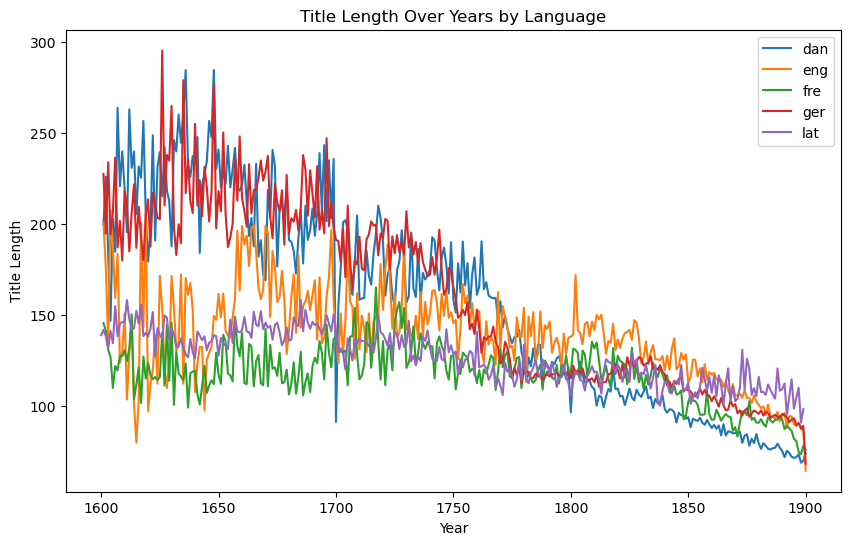

In [7]:
# Plotting
plt.figure(figsize=(10, 6))
for language in yearly_language_title_length['language'].unique():
    subset = yearly_language_title_length[yearly_language_title_length['language'] == language]
    plt.plot(subset['year_st'], subset['title_length'], label=language)

plt.xlabel('Year')
plt.ylabel('Title Length')
plt.title('Title Length Over Years by Language')
plt.legend()
plt.show()


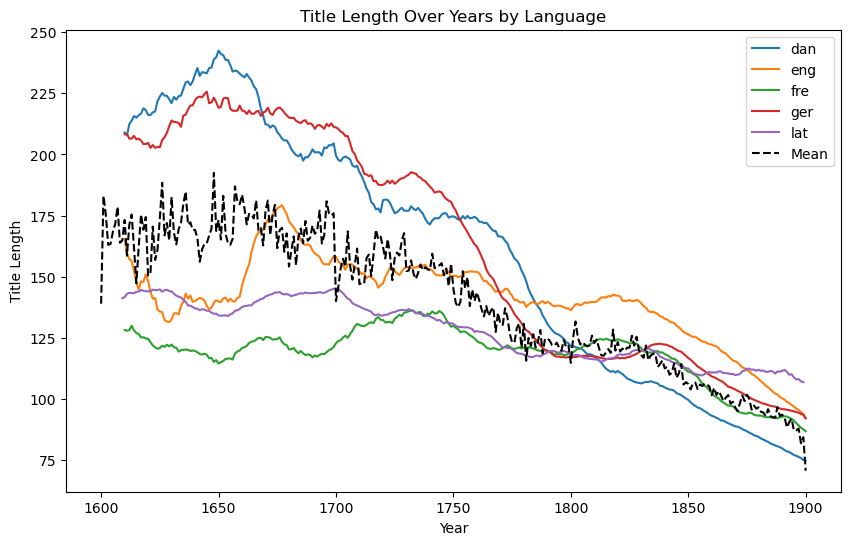

In [8]:
# Calculate the mean title length for each year
mean_title_length = yearly_language_title_length.groupby('year_st')['title_length'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

for language in yearly_language_title_length['language'].unique():
    subset = yearly_language_title_length[yearly_language_title_length['language'] == language]
    
    # Apply rolling average to smooth the curve
    subset = subset.sort_values(by='year_st')
    subset['smoothed_title_length'] = subset['title_length'].rolling(window=20, min_periods=10).mean()
    
    plt.plot(subset['year_st'], subset['smoothed_title_length'], linestyle='-', label=language)
    

# Plot the mean title length
plt.plot(mean_title_length['year_st'], mean_title_length['title_length'], label='Mean', linestyle='--', color='black')

plt.xlabel('Year')
plt.ylabel('Title Length')
plt.title('Title Length Over Years by Language')
plt.legend()
plt.show()

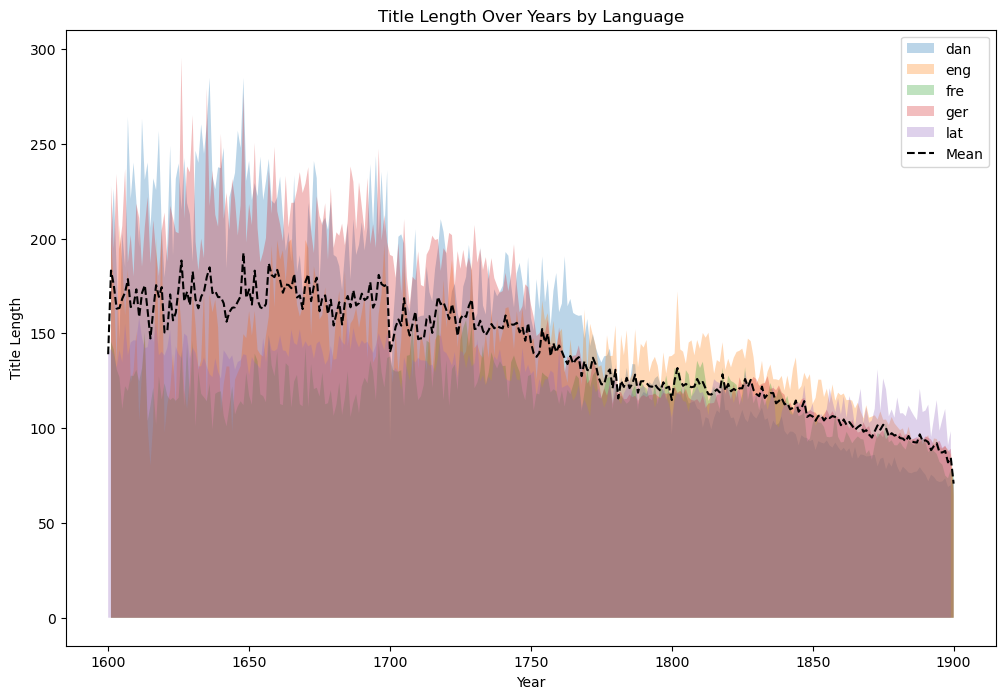

In [13]:
# Create a copy of the slice
yearly_language_title_length = yearly_language_title_length.copy()

# Check and convert 'year_st' and 'title_length' to numeric, forcing errors to NaN
yearly_language_title_length['year_st'] = pd.to_numeric(yearly_language_title_length['year_st'], errors='coerce')
yearly_language_title_length['title_length'] = pd.to_numeric(yearly_language_title_length['title_length'], errors='coerce')

# Drop rows with NaN values in 'year_st' or 'title_length'
yearly_language_title_length = yearly_language_title_length.dropna(subset=['year_st', 'title_length'])

# Plotting mean title length
mean_title_length = yearly_language_title_length.groupby('year_st')['title_length'].mean().reset_index()

plt.figure(figsize=(12, 8))

# Group by language
groups = yearly_language_title_length.groupby('language')

for name, group in groups:
    plt.fill_between(group['year_st'], group['title_length'], alpha=0.3, label=name)

# Plot the mean title length
plt.plot(mean_title_length['year_st'], mean_title_length['title_length'], label='Mean', linestyle='--', color='black')

plt.xlabel('Year')
plt.ylabel('Title Length')
plt.title('Title Length Over Years by Language')
plt.legend()
plt.show()

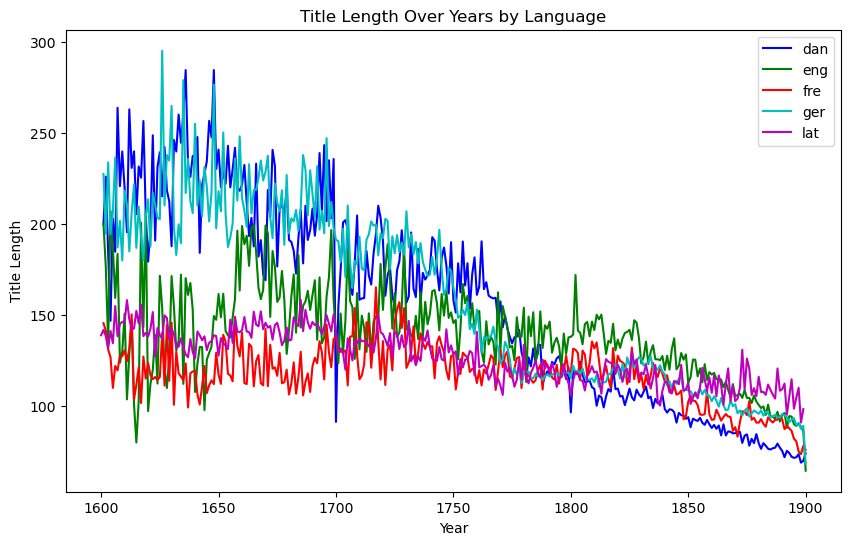

In [10]:
### Different Colors for Each Language

colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(10, 6))
for i, language in enumerate(yearly_language_title_length['language'].unique()):
    subset = yearly_language_title_length[yearly_language_title_length['language'] == language]
    plt.plot(subset['year_st'], subset['title_length'], color=colors[i % len(colors)], label=language)

plt.xlabel('Year')
plt.ylabel('Title Length')
plt.title('Title Length Over Years by Language')
plt.legend()
plt.show()


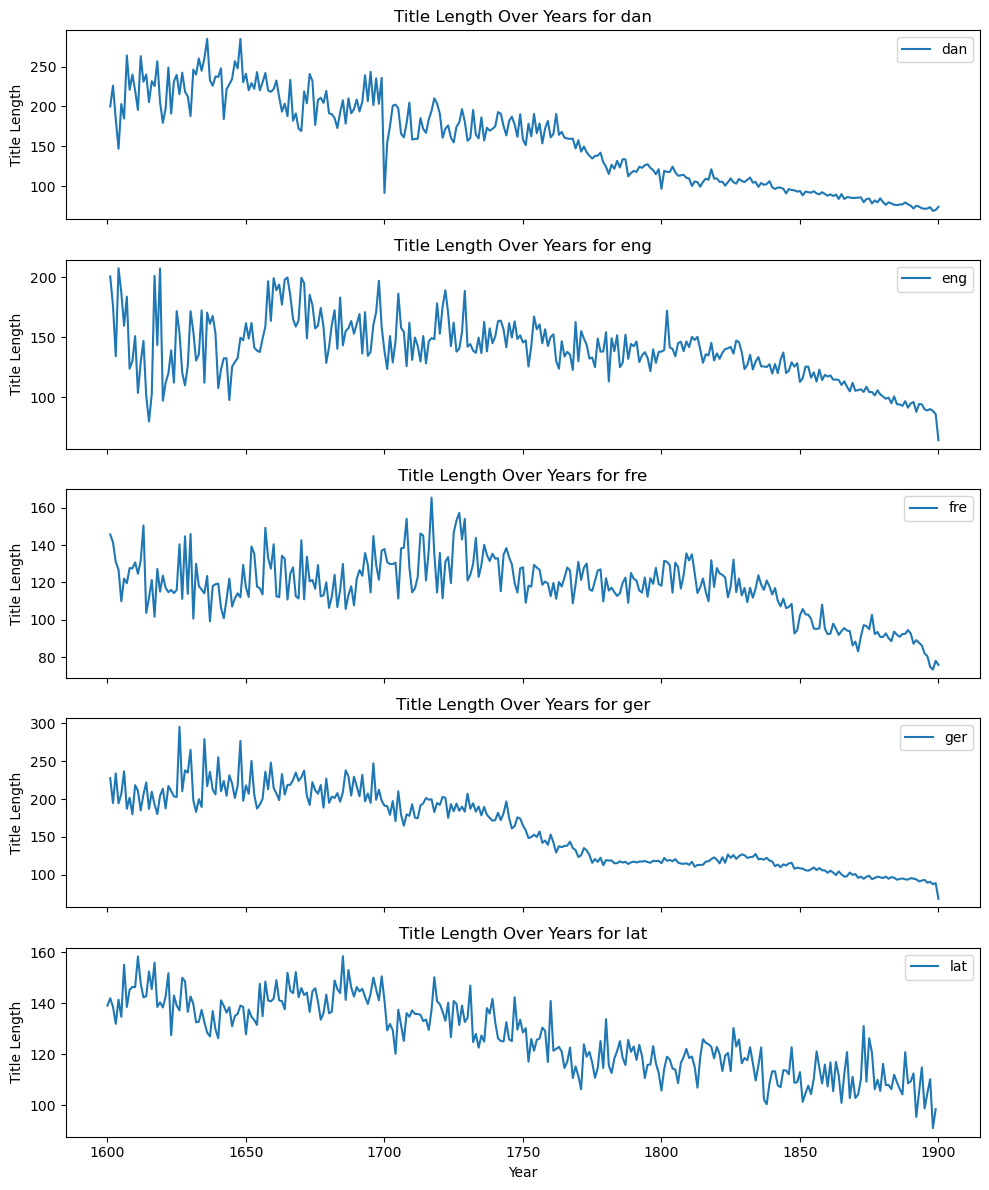

In [11]:
### Using Subplots for Each Language
languages = yearly_language_title_length['language'].unique()
fig, axs = plt.subplots(len(languages), 1, figsize=(10, 12), sharex=True)

for i, language in enumerate(languages):
    subset = yearly_language_title_length[yearly_language_title_length['language'] == language]
    axs[i].plot(subset['year_st'], subset['title_length'], label=language)
    axs[i].set_title(f'Title Length Over Years for {language}')
    axs[i].set_ylabel('Title Length')
    axs[i].legend()

plt.xlabel('Year')
plt.tight_layout()
plt.show()

In [19]:
yearly_language_title_length.sample(50)

,language,year_st,title_length
1308,ger,1784,115.380482
621,eng,1812,147.719178
1722,lat,1801,114.234637
457,eng,1648,149.552632
701,eng,1892,88.034799
1229,ger,1705,210.282895
1421,ger,1897,90.803403
627,eng,1818,145.293286
1757,lat,1836,122.584795
1296,ger,1772,135.384853


<Figure size 1000x600 with 0 Axes>

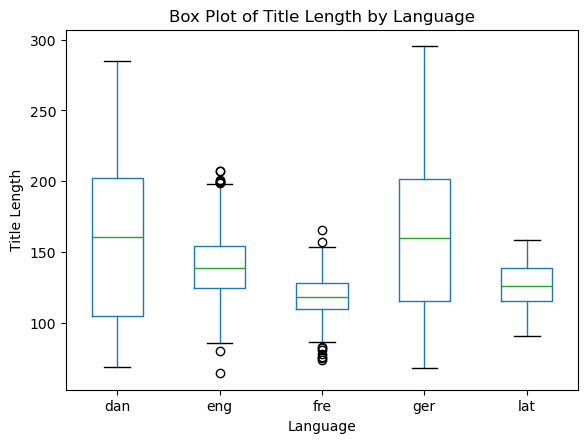

In [17]:
# Create a box plot
plt.figure(figsize=(10, 6))
yearly_language_title_length.boxplot(column='title_length', by='language', grid=False)
plt.title('Box Plot of Title Length by Language')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Language')
plt.ylabel('Title Length')
plt.show()

<Figure size 1200x800 with 0 Axes>

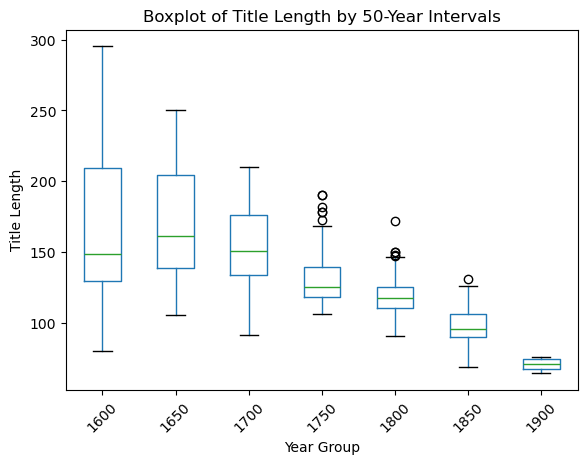

In [22]:
yearly_language_title_length1 = yearly_language_title_length.copy()
# Create a new column for the 50-year intervals
yearly_language_title_length1['year_group'] = (yearly_language_title_length1['year_st'] // 50) * 50

# Create boxplots for each 50-year interval
plt.figure(figsize=(12, 8))
yearly_language_title_length1.boxplot(column='title_length', by='year_group', grid=False)
plt.title('Boxplot of Title Length by 50-Year Intervals')
plt.suptitle('')  # Suppress the default title to avoid overlap
plt.xlabel('Year Group')
plt.ylabel('Title Length')
plt.xticks(rotation=45)
plt.show()

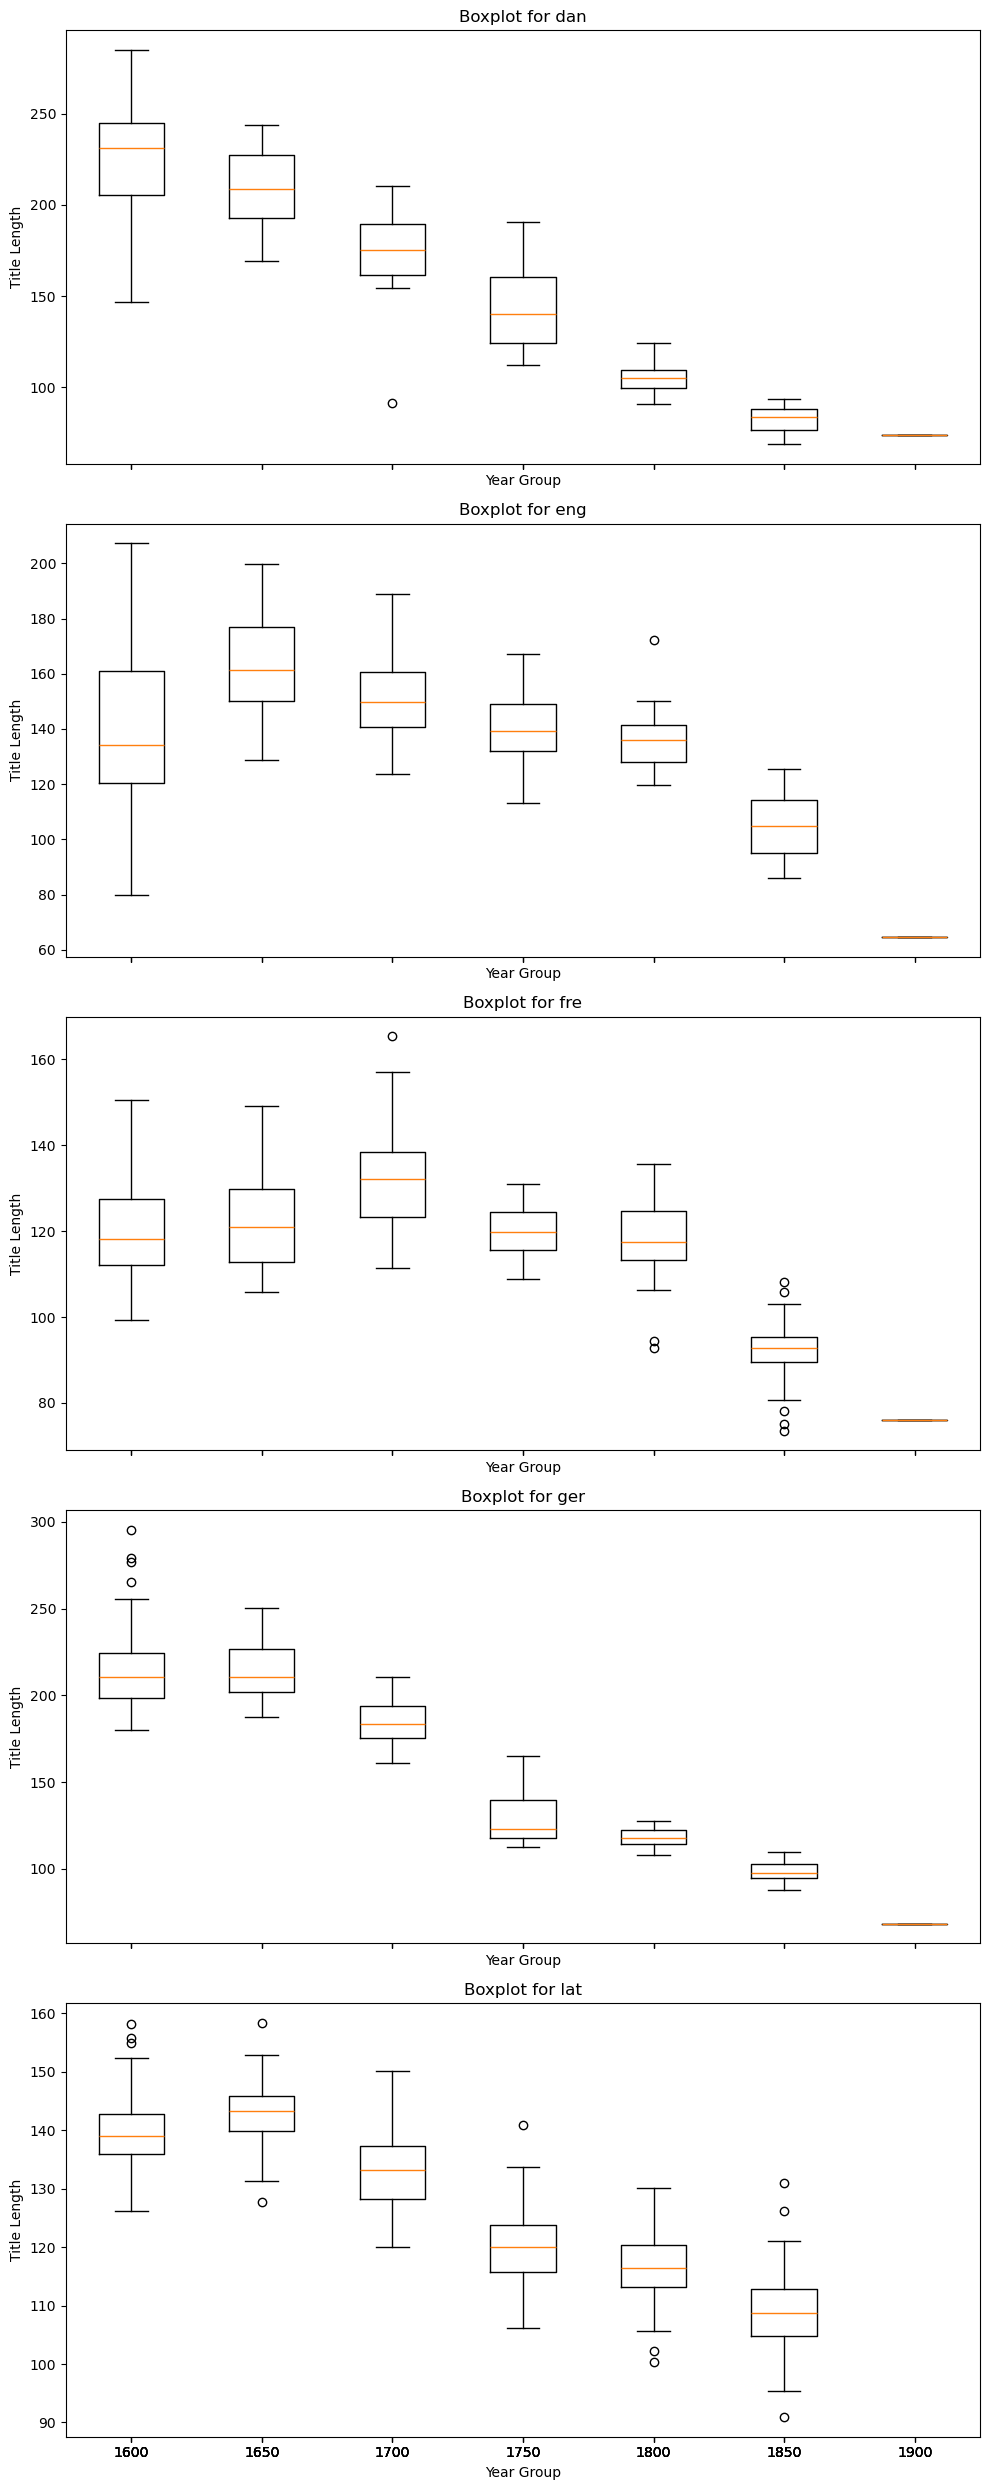

In [23]:
yearly_language_title_length1 = yearly_language_title_length.copy()

# Create a new column for 50-year intervals
yearly_language_title_length1['year_group'] = (yearly_language_title_length1['year_st'] // 50) * 50

# Group by language and year_group
grouped = yearly_language_title_length1.groupby(['language', 'year_group'])

# Create boxplots for each language
languages = yearly_language_title_length1['language'].unique()
fig, axes = plt.subplots(len(languages), 1, figsize=(10, 5 * len(languages)), sharex=True)

for i, language in enumerate(languages):
    ax = axes[i]
    data_to_plot = [group['title_length'].values for name, group in grouped if name[0] == language]
    labels = [name[1] for name, group in grouped if name[0] == language]
    ax.boxplot(data_to_plot, labels=labels)
    ax.set_title(f'Boxplot for {language}')
    ax.set_xlabel('Year Group')
    ax.set_ylabel('Title Length')

plt.tight_layout()
plt.show()